# Turbulence diagnostics
After completing the post-processing, we can now move on to looking at some turbulence diagnostics. 
Based on the generated half-hourly output of the first notebook ([01_post-processing.ipynb](https://github.com/noctiluc3nt/ec_analyze/blob/main/notebooks/01_post-processing.ipynb)) some standard turbulence quantities, i.e. stability parameter, friction velocity, TKE, turbulence intensity are calculated and plotted, which allow to study flow properties.

In [1]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE)
library(Reddy)
library(latex2exp)
kap=function() return(0.4)

Installing package into ‘/home/lauracma/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [2]:
#read in processed example data
dat=readRDS("../data/ec-data_30min_processed/processed_data_example.rds")

## Calculation of standard turbulence diagnostics and simple timeseries plots
Here, some functions from the Reddy package are used to calculate turbulent kinetic energy $TKE$, velocity scale of TKE $V_{TKE}$, horizontal turbulence intensity $TI$, vertical turbulence intensity $I_w$, friction velocity $u_*$, Obukhov length $L$, stability parameter $\zeta$ and directional shear angle and plot their timeseries for the previously post-processed example data. <br>


- **Turbulence intensity** (`calc_ti` and `calc_iw`): Turbulence intensity generally refers to the standard deviation, e.g., $\sigma_u, \sigma_v, \sigma_w, \sigma_T$, and thus describes the mean fluctuation intensity. The horizontal turbulence intensity TI (`calc_ti`) and the vertical turbulence intensity $I_w$ (`calc_iw`) are calculated by normalizing the respective standard deviations with the mean wind speed $\overline{u}$:
$$TI = ,\quad\quad I_w= \frac{\sigma_w}{\overline{u}} $$
- **Turbulent kinetic energy TKE** (`calc_tke`): TKE describes the mean kinetic energy that the eddies contain and is calculated by
 $$ TKE = 0.5 (\sigma_u^2 + \sigma_v^2 + \sigma_w^2) =0.5 (\overline{u'^2} + \overline{v'^2} + \overline{w'^2}  ).$$
 From the TKE, a velocity scale can easily be derived $V_{TKE} = \sqrt{TKE}$ (`calc_vtke`).
- **Friction velocity** $u_*$ (`calc_ustar`): The friction velocity describes the effect of friction in form of a velocity scale
$$ u_* = \sqrt[4]{\overline{u'v'}^2+\overline{v'w'}^2}.$$
- **Obukhov length** $L$ (`calc_L`): The Obukhov length is a length scale that describes the effect of buoyancy 
$$ L = -\frac{u_*^3 \overline{T_v}}{\kappa \,g\,\overline{w'T'}}, $$
which is central in Monin-Obukhov similarity theory (MOST) to derive dimensionless scaling parameter, like the stability parameter $\zeta$.
The fluxes used in the calculation are either the surface fluxes for global scaling or the fluxes at the measurement height for local scaling.
- **Stability parameter** $\zeta$ (`calc_zeta`): The stability parameter is the ratio of Obukhov length and measurement height and thus a dimensionless measure for stability
$$ \zeta = \frac{z}{L}.$$

In [3]:
#calculation of some useful turbulence diagnostics
dat$tke=calc_tke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$vtke=calc_vtke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$ti=calc_ti(dat$u_sd,dat$v_sd,dat$ws_mean)
dat$iw=calc_iw(dat$w_sd,dat$ws_mean)
dat$ustar=calc_ustar(dat$cov_uw,dat$cov_vw)
dat$L=calc_L(dat$ustar,dat$T_mean,dat$cov_wT)
dat$zeta=calc_zeta(4.4,dat$L)
dat$alpha_uw=calc_dshear(dat$cov_uw,dat$cov_vw)

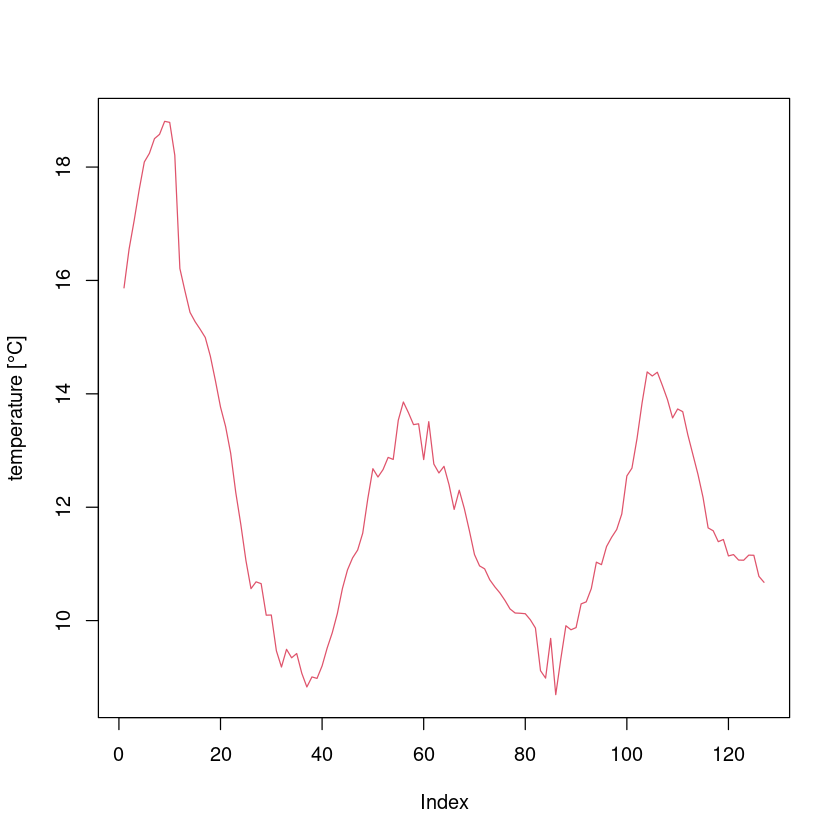

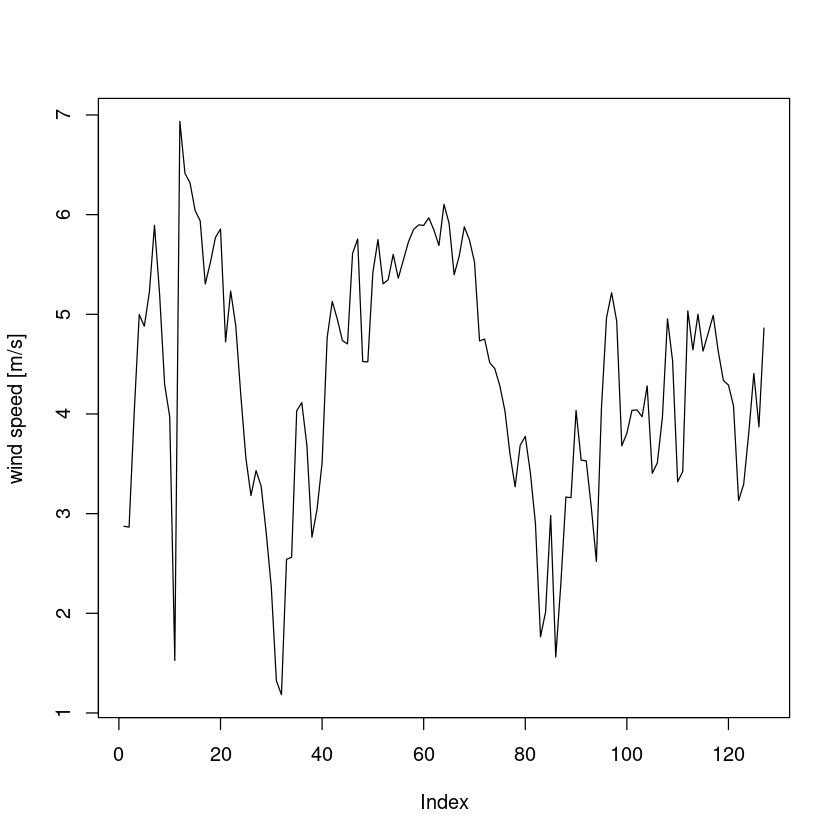

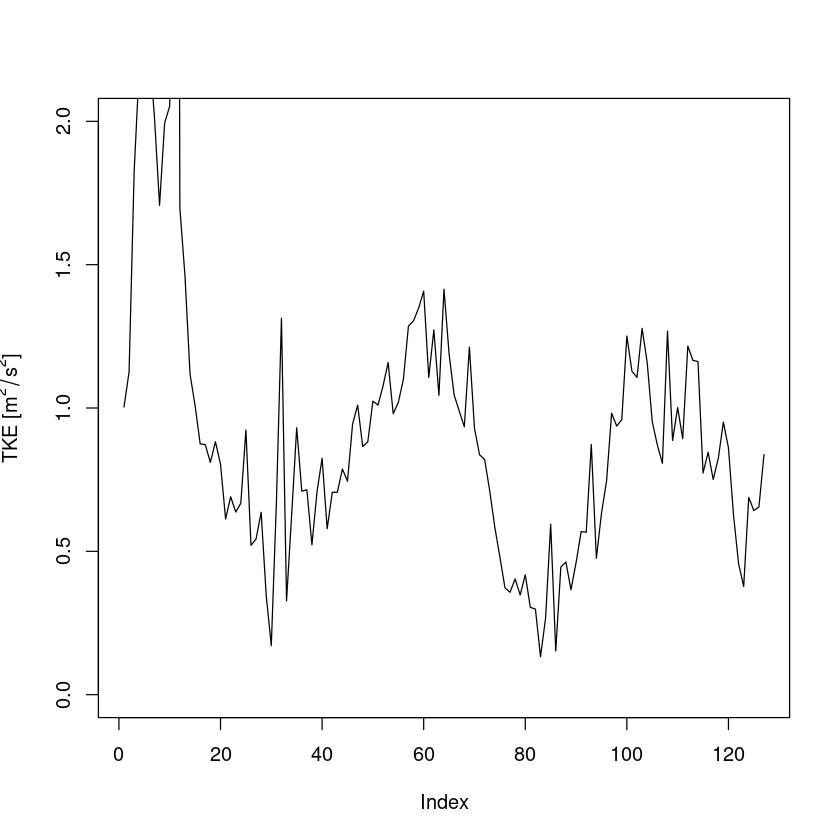

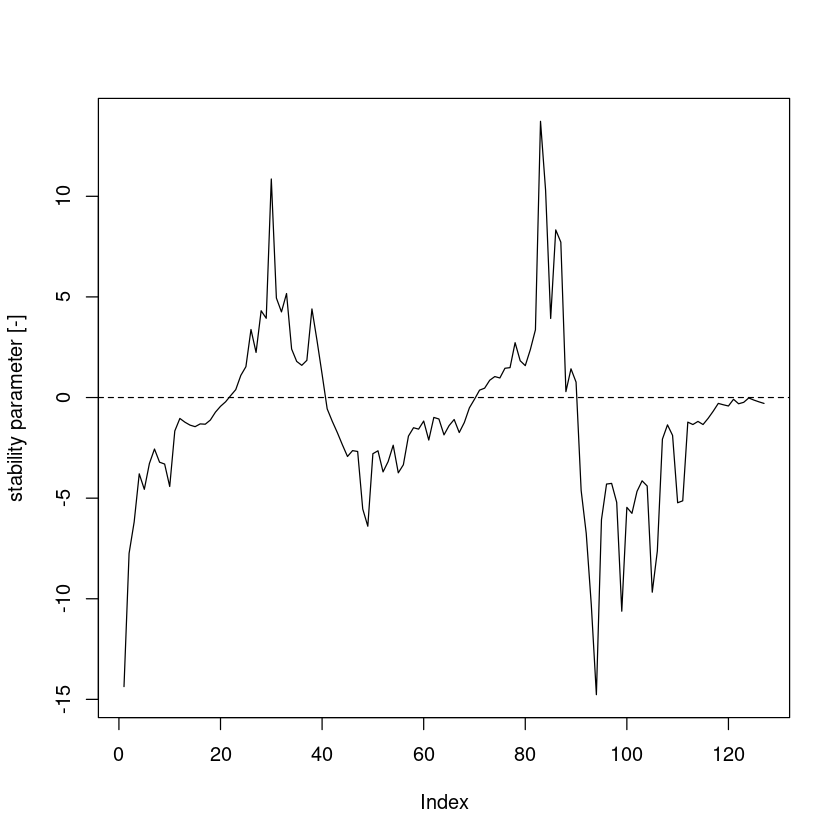

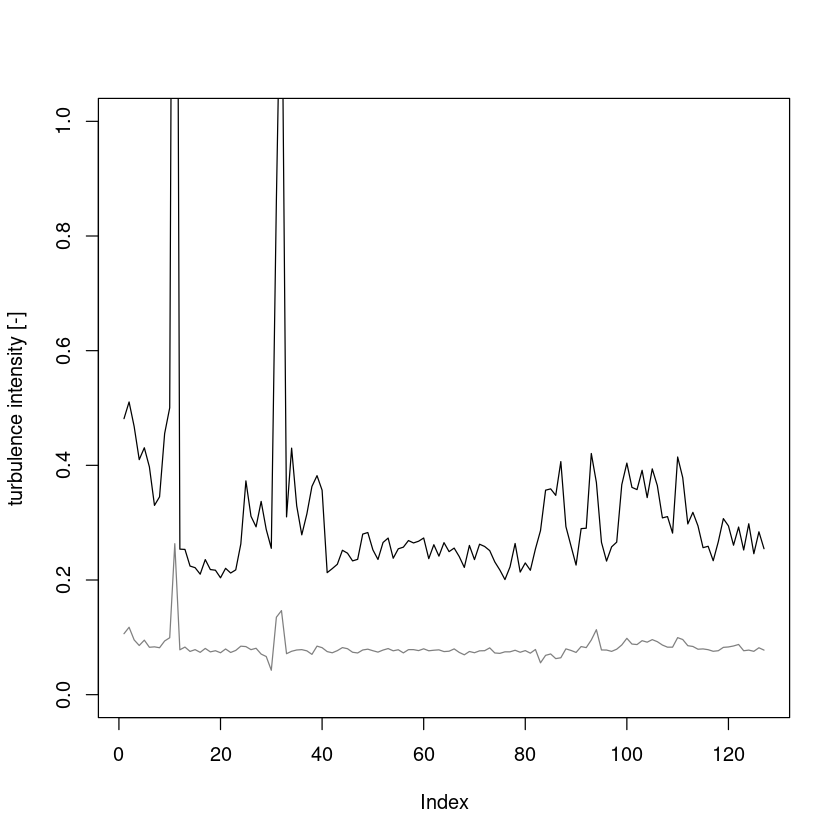

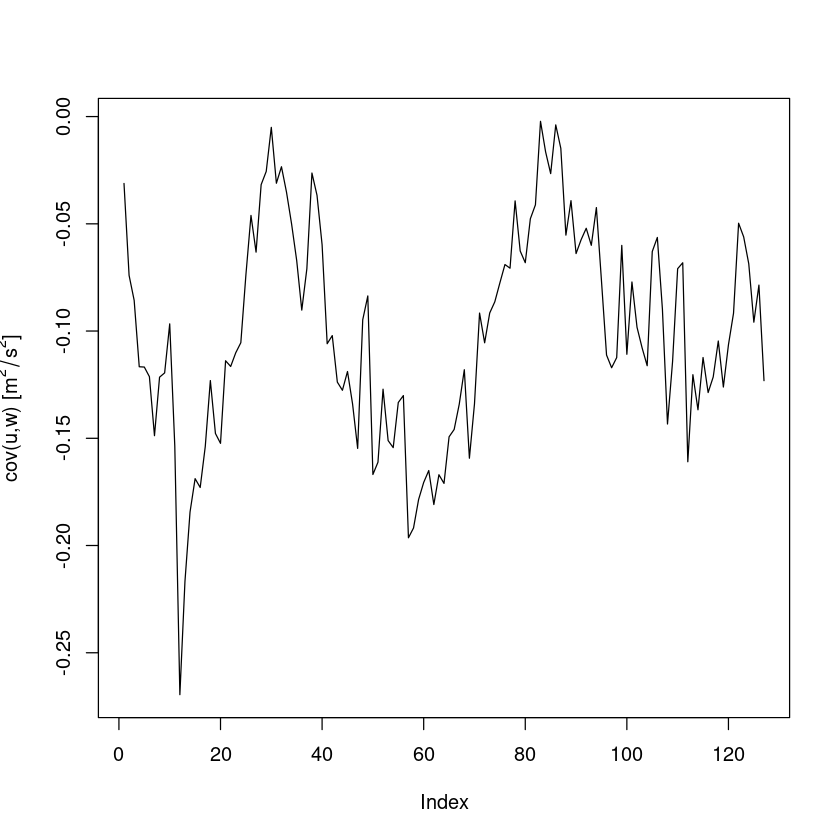

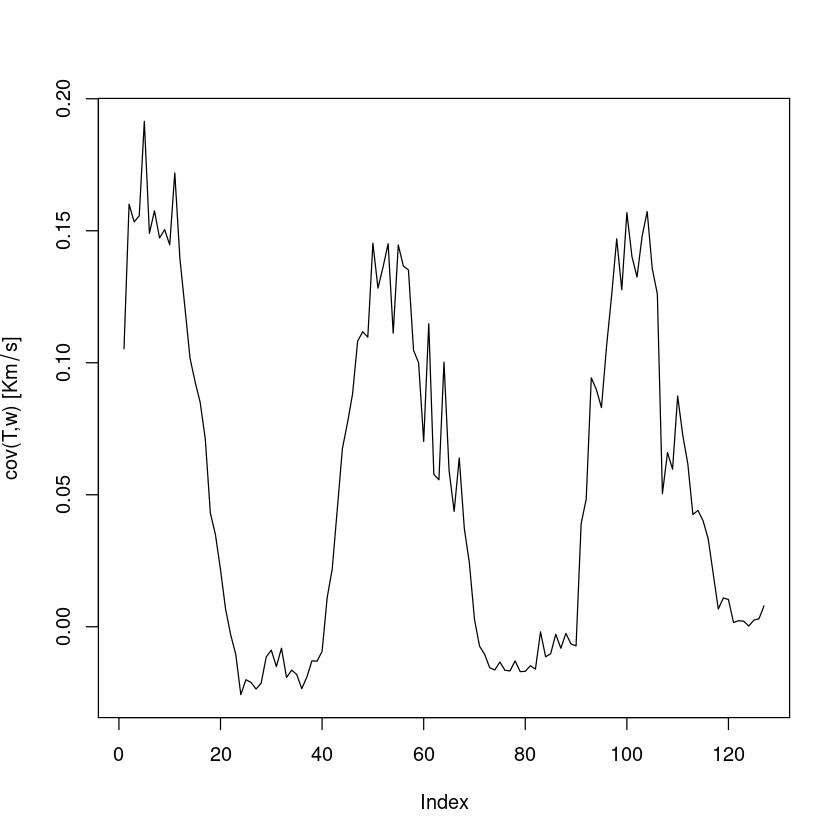

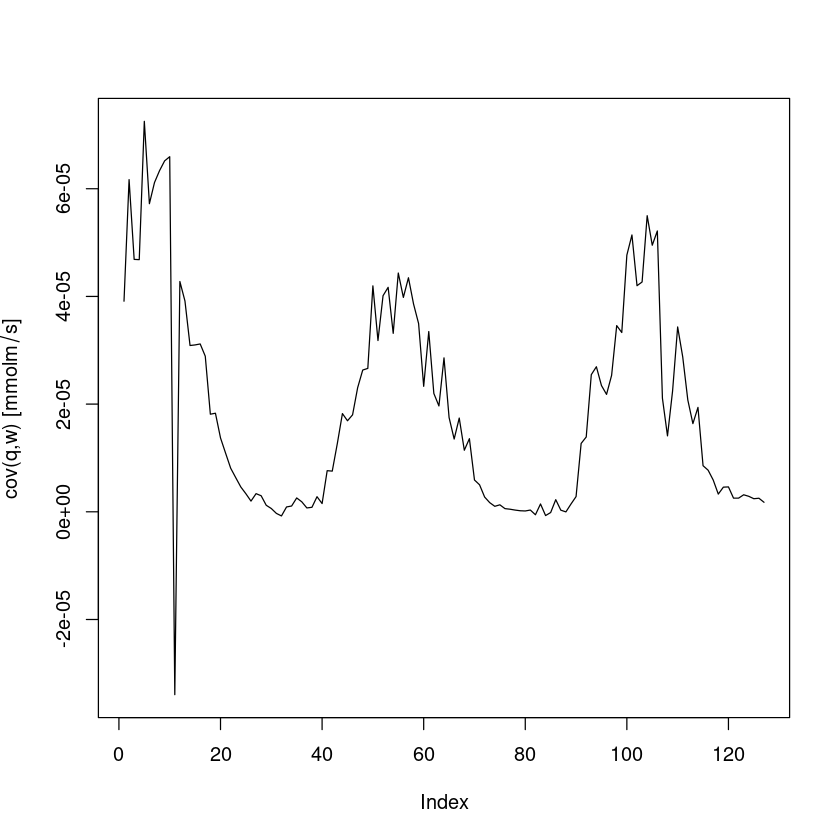

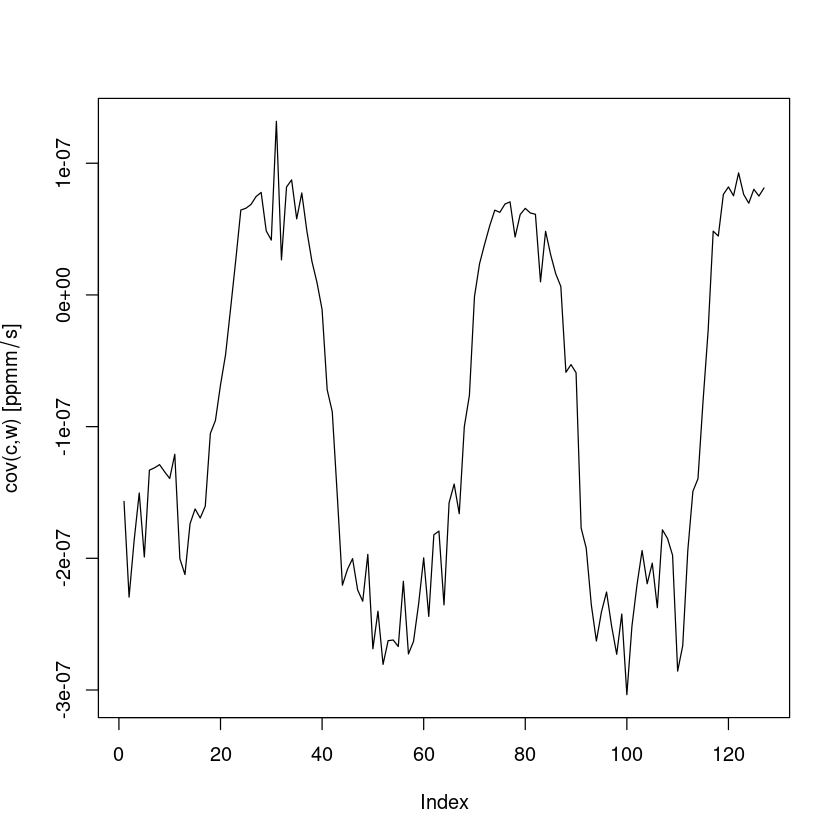

In [5]:
#basic timeseries plots
plot(dat$T_mean,type="l",ylab="temperature [°C]",col=2)
plot(dat$ws_mean,type="l",ylab="wind speed [m/s]")
plot(dat$tke,type="l",ylab=TeX("TKE [$m^2/s^2$]"),ylim=c(0,2))
plot(dat$zeta,type="l",ylab="stability parameter [-]")
abline(h=0,lty=2)
plot(dat$ti,type="l",ylab="turbulence intensity [-]",ylim=c(0,1))
points(dat$iw,type="l",col="gray50")
plot(dat$cov_uw,type="l",ylab=TeX("cov(u,w) [$m^2/s^2$]"))
plot(dat$cov_wT,type="l",ylab=TeX("cov(T,w) [$K m/s$]"))
plot(dat$cov_h2ow,type="l",ylab=TeX("cov(q,w) [$mmol m/s$]"))
plot(dat$cov_co2w,type="l",ylab=TeX("cov(c,w) [$ppm m/s$]"))

## Regime plots
To diagnose different turbulence regimes, scatter plots of different turbulence diagnostics can be used. Here are some examples plotting wind speed vs TKE or stability parameter vs TKE (see e.g., Sun et al., 2012).

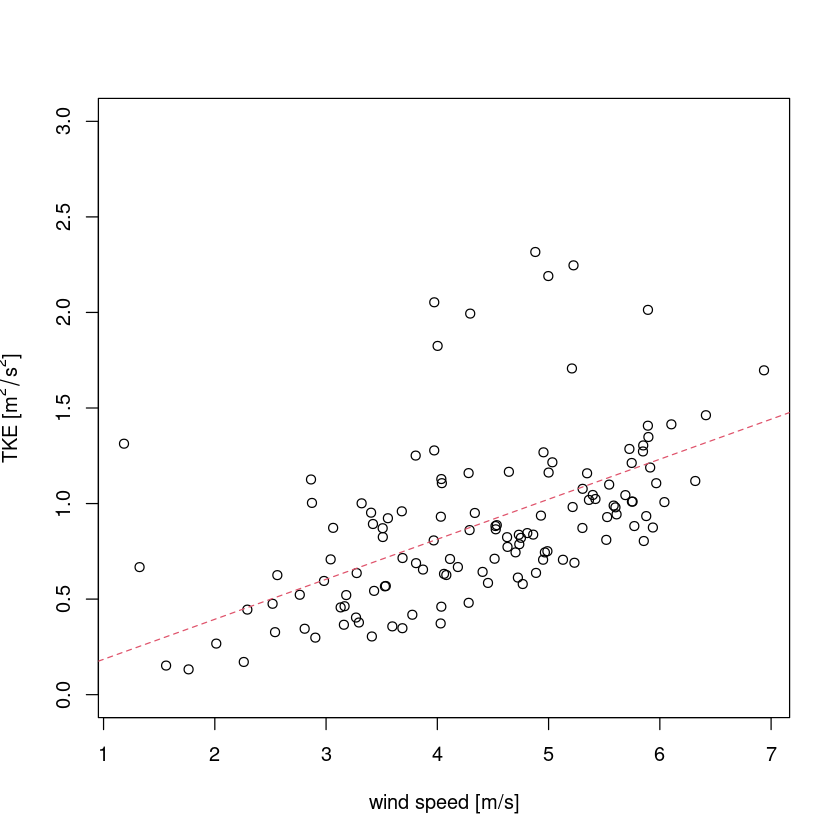

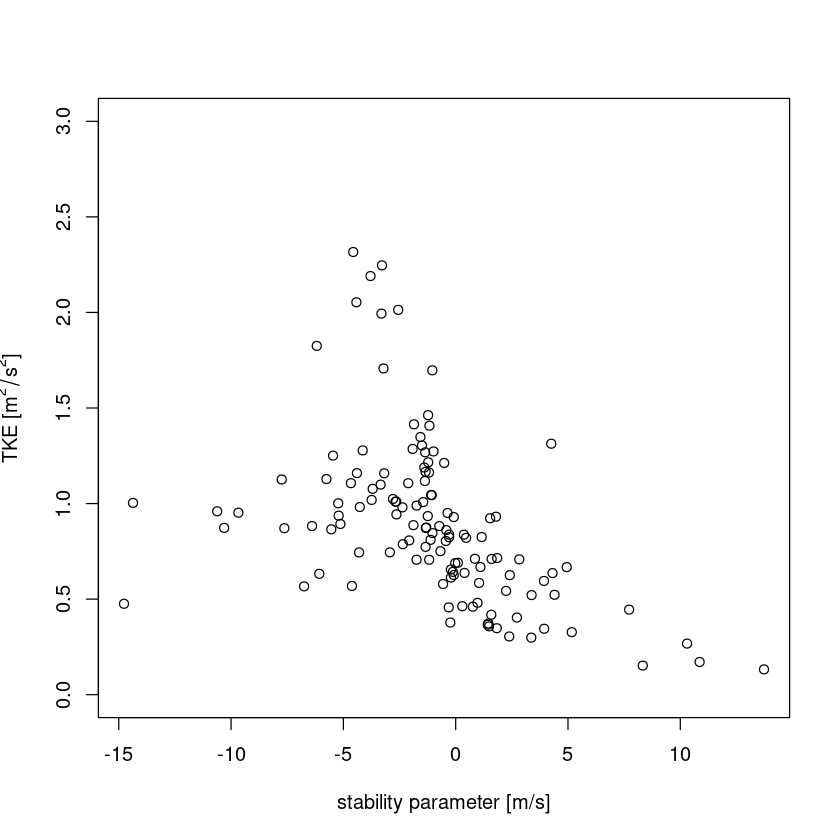

In [6]:
#some basic plots
plot(dat$ws_mean,dat$tke,ylim=c(0,3),xlab="wind speed [m/s]",ylab=TeX("TKE [$m^2/s^2$]"))
cond=(dat$ws_mean>2)
fit=lm(dat$tke[cond]~dat$ws_mean[cond])
abline(fit,col=2,lty=2)

plot(dat$zeta,dat$tke,ylim=c(0,3),xlab="stability parameter [m/s]",ylab=TeX("TKE [$m^2/s^2$]"))

## Stability dependence
Often it is interesting to investigate the stability dependence of turbulence characteristics. For this the function `binning` can be used, which bins one variable based on another for predefined bins, as exemplified below for the dependence of the sensible heat flux on the stability parameter. The output contains mean, median, 25% and 75% quartile per discrete bin as dataframe. The used variables and the bins can be customized. Such type of analysis is usually applied to longer timeseries. 

122.045246,116.804837,109.052920,129.797163
120.620398,125.471467,75.448402,167.986972
17.306097,12.061651,5.647776,24.415438
1.823135,1.864732,1.093005,2.574063
NA,NA,NA,NA
-3.564331,-3.564331,-3.564331,-3.564331
-11.192381,-12.213284,-13.937180,-8.561890
-18.102981,-19.201199,-22.358905,-14.674265
-8.655841,-10.389901,-11.853905,-6.324807


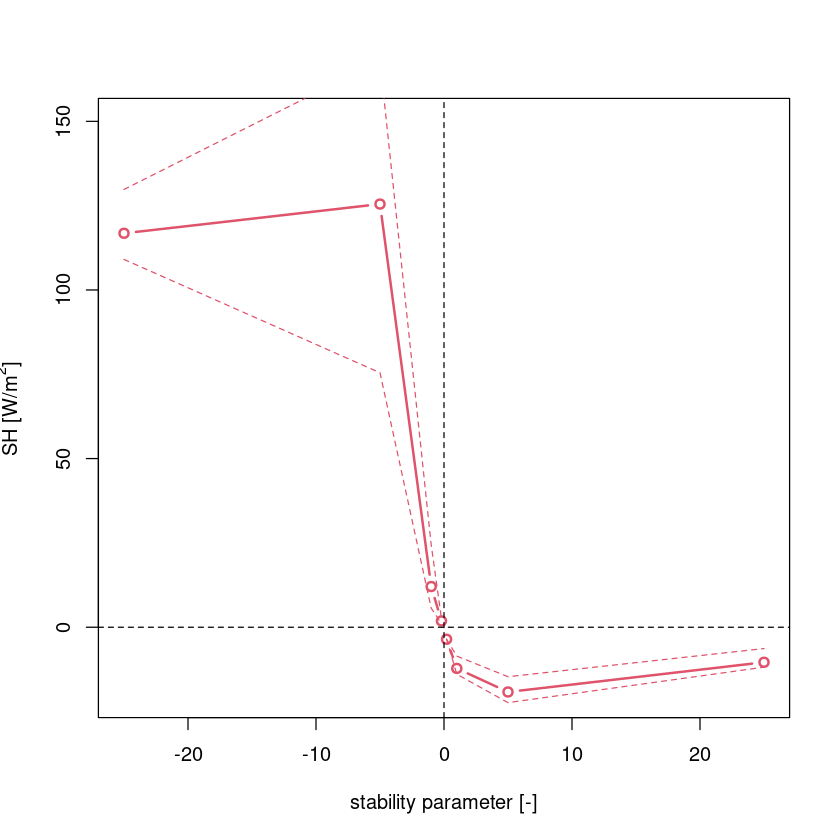

In [21]:
zeta_bins=c(-10^(2:-2),10^(-2:2))
sh_binned=binning(dat$sh,dat$zeta,zeta_bins)
sh_binned #look at output
xbins=c(-5^(2:-1),0,5^(-1:2))
plot(xbins,sh_binned[,2],type="b",ylim=c(-20,150),lwd=2,col=2,xlab="stability parameter [-]",ylab=TeX("SH [W/m$^2$]"))
points(xbins,sh_binned[,3],type="l",lty=2,col=2)
points(xbins,sh_binned[,4],type="l",lty=2,col=2)
abline(h=0,lty=2)
abline(v=0,lty=2)

## Literature
- Sun, J., Mahrt, L., Banta, R. M., and Pichugina, Y. L. (2012). Turbulence Regimes and Turbulence Intermittency in the Stable Boundary Layer during CASES-99. J Atmos Sci, 69:338–351.